# Sampling from density functions related to the Dirichlet-Multinomial distribution and using them to compute the probabilities of sample points, no tears

In [1]:
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

np.random.seed(37)

def factorial(x):
    if x <= 0.0:
        return 1
    
    # typically stirling's approximation would be (x / e)^x
    # for large values of x, this creates an overflow
    # we use 1 here, which doesn't seem to affect the sampling or probability estimations
    g = np.sqrt(2 * np.pi * x) * np.power(x / 2.718281, 1)
    return g

def gamma(n):
    return factorial(n - 1)

def beta(alphas):
    k = len(alphas)
    b = 1.
    for i in range(k):
        b *= gamma(alphas[i])
    b = b / gamma(np.sum(alphas))
    return b

def rgama(a):
    d = a - 1. / 3.
    c = 1. / np.sqrt(9. * d)
    
    while True:
        x = None
        v = -1
        
        while v <= 0:
            x = np.random.normal(0, 1)
            v = 1. + c * x
            
        v = np.power(v, 3)
        u = np.random.uniform()
        
        if u < 1 - 0.0331 * (x * x) * (x * x):
            return d * v
        
        if np.log(u) < 0.5 * x * x + d * (1 - v + np.log(v)):
            return d * v

def dgama(x, alpha):
    d = np.log(np.power(x, alpha - 1)) + np.log(2.718281) - np.log(gamma(alpha))
    return d

def rdirch(alphas):
    k = len(alphas)
    x = np.array([rgama(alphas[i]) for i in range(k)])
    total = np.sum(x)
    x = [s / total for s in x]
    return x

def ddirch(x, alphas):
    k = len(x)
    d = 0.
    for i in range(k):
        d += np.log(np.power(x[i], alphas[i] - 1))
    d -= np.log(1. / beta(alphas))
    return d

def rmultnomial(p):
    k = len(p)
    probs = [prob / np.sum(p) for prob in p]
    x = np.random.uniform()
    cummulative_p = 0
    for i, prob in enumerate(probs):
        cummulative_p += prob
        if cummulative_p - x >= 0:
            return i
    return k - 1

def dmultinomial(x, p):
    k = len(x)
    d = np.log(gamma(np.sum(x + 1)))
    for i in range(k):
        d += np.log(np.power(p[i], x[i]))
    for i in range(k):
        d -= np.log(gamma(x[i] + 1))
    return d

def rdirmultinom(alphas):
    p = rdirch(alphas)
    m = rmultnomial(p)
    return m

def ddirmultinom(x, alphas):
    k = len(x)
    n = np.sum(x)
    sum_alphas = np.sum(alphas)
    
    d = np.log(factorial(n))
    d += np.log(gamma(sum_alphas))
    d -= np.log(gamma(n + sum_alphas))
    
    for i in range(k):
        d += np.log(gamma(x[i] + alphas[i]))
        d -= np.log(factorial(x[i]))
        d -= np.log(gamma(alphas[i]))
        
    return d

# Gamma

In [2]:
x = rgama(1)

print('estimating probability of {} with gamma density functions of different parameters'.format(x))

print(dgama(x, 1))
print(dgama(x, 2))
print(dgama(x, 3))
print(dgama(x, 4))

estimating probability of 0.623178746832 with gamma density functions of different parameters
0.999999695226903
0.6081389689561665
-0.9045036901767185
-1.9856232406319319


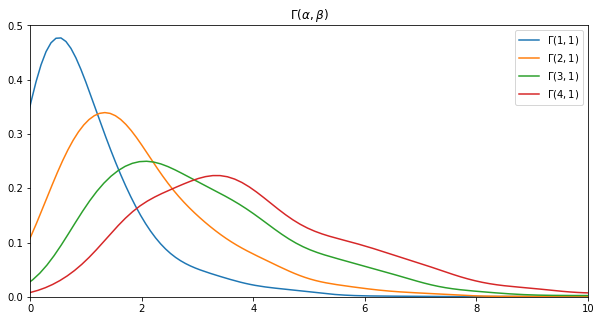

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_xlim([0, 10])
ax.set_title(r'$\Gamma(\alpha, \beta)$')

sns.kdeplot([rgama(1) for _ in range(1000)], bw=0.5, ax=ax, label=r'$\Gamma(1, 1)$')
sns.kdeplot([rgama(2) for _ in range(1000)], bw=0.5, ax=ax, label=r'$\Gamma(2, 1)$')
sns.kdeplot([rgama(3) for _ in range(1000)], bw=0.5, ax=ax, label=r'$\Gamma(3, 1)$')
sns.kdeplot([rgama(4) for _ in range(1000)], bw=0.5, ax=ax, label=r'$\Gamma(4, 1)$')

# Dirichlet

In [4]:
alphas = np.array([1, 2])
x = rdirch(alphas)

print(x)
print(ddirch(x, np.array([1, 2])))
print(ddirch(x, np.array([2, 1])))
print(ddirch(x, np.array([1, 9])))
print(ddirch(x, np.array([9, 1])))
print(ddirch(x, np.array([5, 5])))

[0.8011123776705179, 0.198887622329482]
-2.6547360965195397
-1.2614748158771092
-13.096797158921547
-1.9507069137821034
-6.565092427534137


C:\Users\super\Anaconda3\envs\ds\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


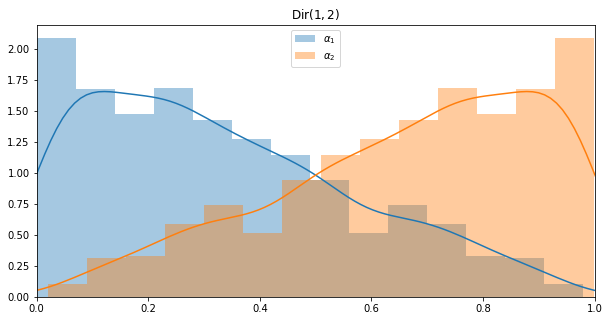

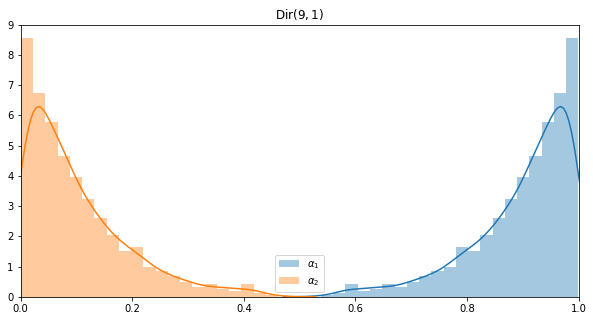

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_xlim([0, 1])
ax.set_title(r'$\operatorname{Dir}(1, 2)$')
x = np.array([rdirch(np.array([1, 2])) for _ in range(1000)])
sns.distplot(x[:, 0], ax=ax, label=r'$\alpha_1$')
sns.distplot(x[:, 1], ax=ax, label=r'$\alpha_2$')
plt.legend()

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_xlim([0, 1])
ax.set_title(r'$\operatorname{Dir}(9, 1)$')
x = np.array([rdirch(np.array([9, 1])) for _ in range(1000)])
sns.distplot(x[:, 0], ax=ax, label=r'$\alpha_1$')
sns.distplot(x[:, 1], ax=ax, label=r'$\alpha_2$')
plt.legend()

# Multinomial

In [6]:
num_ones = 0
for i in range(1000):
    v = rmultnomial(np.array([0.1, 0.9]))
    if v == 1:
        num_ones += 1
        
print('k = 2, p = [0.1, 0.9]')
print(num_ones / 1000.)

num_zeros = 0
num_ones = 0
num_twos = 0

for i in range(1000):
    v = rmultnomial(np.array([0.1, 0.8, 0.1]))
    if v == 0:
        num_zeros += 1
    elif v == 1:
        num_ones += 1
    else:
        num_twos += 1

print('')
print('k = 3, p = [0.1, 0.8, 0.1]')
print(num_zeros / 1000.)
print(num_ones / 1000.)
print(num_twos / 1000.)

k = 2, p = [0.1, 0.9]
0.895

k = 3, p = [0.1, 0.8, 0.1]
0.106
0.793
0.101


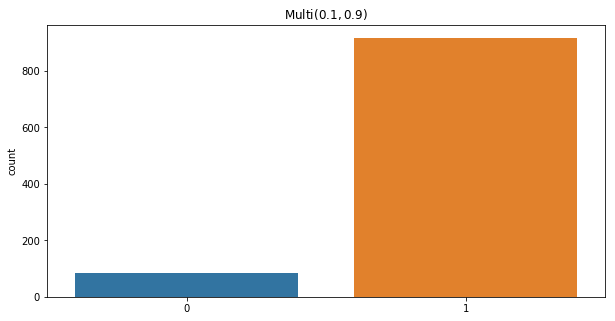

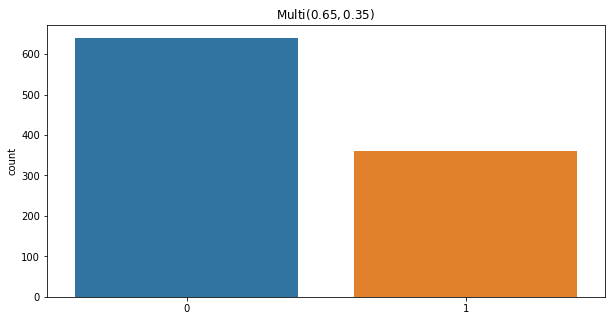

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_title(r'$\operatorname{Multi}(0.1, 0.9)$')
x = np.array([rmultnomial(np.array([0.1, 0.9])) for _ in range(1000)])
sns.countplot(x)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_title(r'$\operatorname{Multi}(0.65, 0.35)$')
x = np.array([rmultnomial(np.array([0.65, 0.35])) for _ in range(1000)])
sns.countplot(x)

In [8]:
for p in np.linspace(0, 1, 11):
    q = 1.0 - p
    d = dmultinomial(np.array([2, 8]), np.array([p, q]))
    print('p_1 = {}, p_2 = {}, prob = {}'.format(p, q, d))

p_1 = 0.0, p_2 = 1.0, prob = -inf
p_1 = 0.1, p_2 = 0.9, prob = -5.92903332339
p_1 = 0.2, p_2 = 0.8, prob = -5.48500324752
p_1 = 0.3, p_2 = 0.7, prob = -5.7423241723
p_1 = 0.4, p_2 = 0.6, prob = -6.40016546602
p_1 = 0.5, p_2 = 0.5, prob = -7.41245081774
p_1 = 0.6, p_2 = 0.4, prob = -8.83295611467
p_1 = 0.7, p_2 = 0.3, prob = -10.8261113346
p_1 = 0.8, p_2 = 0.2, prob = -13.8027694142
p_1 = 0.9, p_2 = 0.1, prob = -19.1123807874
p_1 = 1.0, p_2 = 0.0, prob = -inf


C:\Users\super\Anaconda3\envs\ds\lib\site-packages\ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in log


# Dirichlet-multinomial

In [9]:
count_0 = 0
count_1 = 0

for i in range(100):
    v = rdirmultinom(np.array([2, 8]))
    if v == 0:
        count_0 += 1
    else:
        count_1 += 1

print('count_0 = {}, count_1 = {}'.format(count_0, count_1))

for alpha_0 in np.linspace(0, 10, 11):
    alpha_1 = 10 - alpha_0
    d = ddirmultinom(np.array([count_0, count_1]), np.array([alpha_0, alpha_1]))
    print('alpha = [{}, {}], prob = {}'.format(alpha_0, alpha_1, d))

count_0 = 20, count_1 = 80
alpha = [0.0, 10.0], prob = -0.0462918833555
alpha = [1.0, 9.0], prob = 0.190373278829
alpha = [2.0, 8.0], prob = 0.527773732307
alpha = [3.0, 7.0], prob = -0.228282228941
alpha = [4.0, 6.0], prob = -0.513863971701
alpha = [5.0, 5.0], prob = -0.56458401825
alpha = [6.0, 4.0], prob = -0.424507531333
alpha = [7.0, 3.0], prob = -0.0491431754302
alpha = [8.0, 2.0], prob = 0.797556928755
alpha = [9.0, 1.0], prob = 0.552116364055
alpha = [10.0, 0.0], prob = 0.409210616977


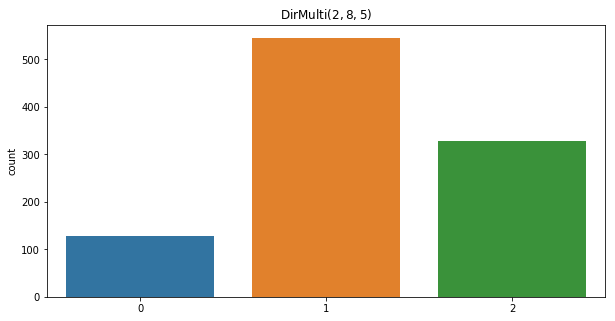

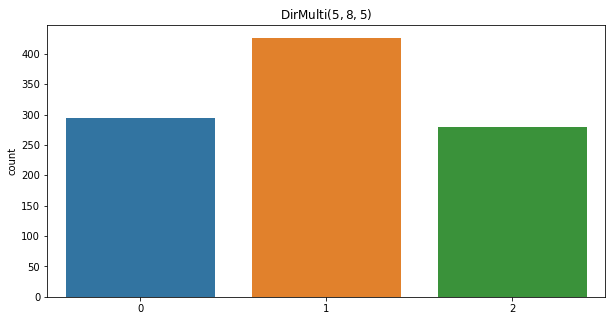

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_title(r'$\operatorname{DirMulti}(2, 8, 5)$')
x = np.array([rdirmultinom(np.array([2, 8, 5])) for _ in range(1000)])
sns.countplot(x)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_title(r'$\operatorname{DirMulti}(5, 8, 5)$')
x = np.array([rdirmultinom(np.array([5, 8, 5])) for _ in range(1000)])
sns.countplot(x)

# References

* [Dirichlet distribution](https://en.wikipedia.org/wiki/Dirichlet_distribution)
* [How to generate gamma random variables](http://www.hongliangjie.com/2012/12/19/how-to-generate-gamma-random-variables/)
* [Stirling's approximation](https://en.wikipedia.org/wiki/Stirling%27s_approximation)